In [3]:
import torch
torch.cuda.is_available()

False

In [4]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torchvision.datasets import CelebA, ImageFolder # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!  

/Users/snehasundar/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

In [6]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [7]:
# build the generator class
class Generator(nn.Module):
    
    def __init__(self, z_dim=100, im_dim=12288, hidden_dim=64):
        super(Generator, self).__init__()
        # build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            get_generator_block(hidden_dim * 8, hidden_dim * 16),
            nn.Linear(hidden_dim * 16, im_dim),
            nn.Tanh()  # Use Tanh activation for the last layer to output values in [-1, 1]
        )
    
    def forward(self, noise):
        return self.gen(noise)

In [8]:
def get_noise(batch_size, z_dim, device='cpu'):
    '''
    Function to generate a batch of noise vectors (z) that will be used as input to the generator.
    
    Parameters:
        batch_size: Size of the batch, a scalar
        z_dim: Dimension of the noise vector (z), a scalar
        device: Device (CPU or GPU) where the tensor will be allocated
    
    Returns:
        A tensor of shape (batch_size, z_dim) containing noise vectors sampled from a normal distribution
    '''
    return torch.randn(batch_size, z_dim, device=device)

In [9]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network block of the discriminator given input and output dimensions.
    
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
        
    Returns:
        a discriminator neural network layer, with a linear transformation 
        followed by an nn.LeakyReLU activation with negative slope of 0.2
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [10]:
# build the discriminator class
class Discriminator(nn.Module):
    def __init__(self, im_dim=12288, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, image):
        return self.disc(image)

In [11]:
# training our model !!

# parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
lr = 0.0002

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize image to 64x64
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    # Add more transformations if needed
])



In [12]:
# Load dataset
dataset_path = 'data/img_align_celeba'
image_dataset = ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(
    dataset=image_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [13]:

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [14]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [15]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss

 32%|███▏      | 500/1583 [01:23<02:57,  6.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 500: Generator loss: 37.69157996785641, discriminator loss: 0.07782083175284776


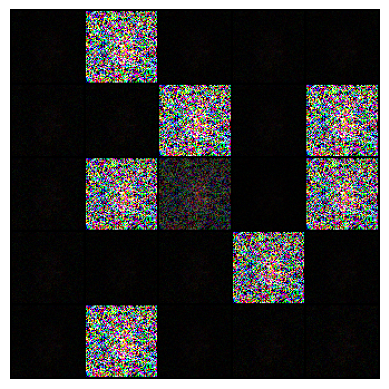

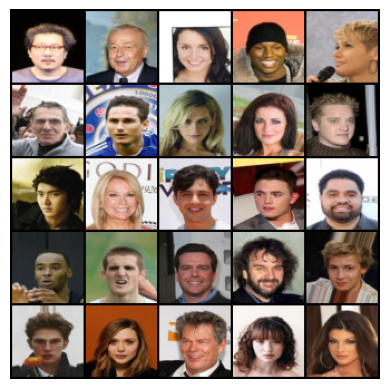

 63%|██████▎   | 1000/1583 [02:50<01:43,  5.61it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 1000: Generator loss: 25.496076810836772, discriminator loss: 0.0021633511719992378


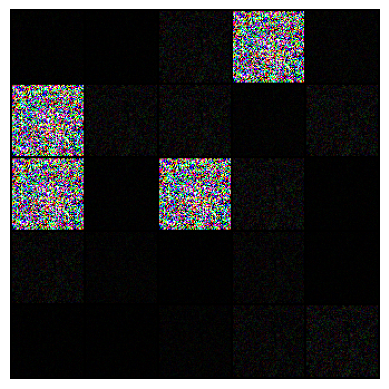

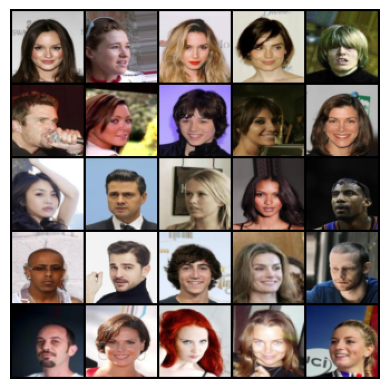

 95%|█████████▍| 1500/1583 [04:16<00:14,  5.79it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 1500: Generator loss: 25.92463588714599, discriminator loss: 0.2512534186687365


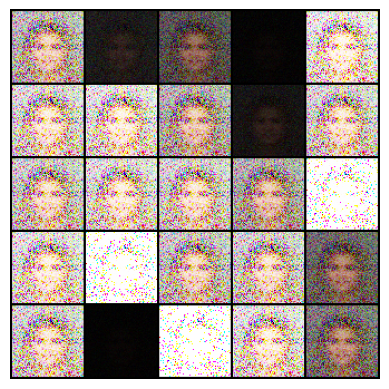

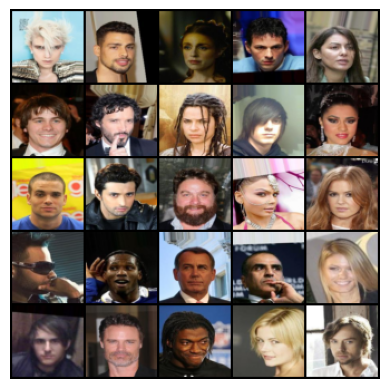

 26%|██▋       | 417/1583 [01:17<03:25,  5.67it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 2000: Generator loss: 15.529162610054009, discriminator loss: 0.12337917510978884


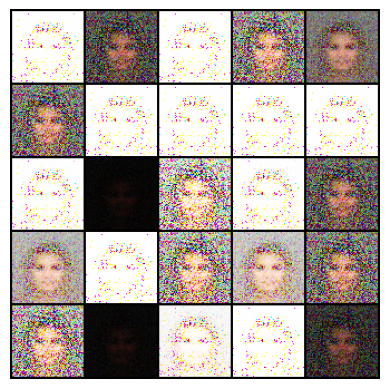

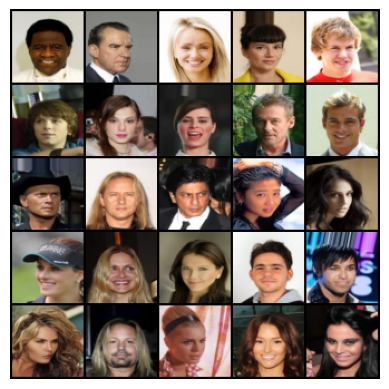

 58%|█████▊    | 917/1583 [02:48<01:56,  5.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 2500: Generator loss: 4.196698641538623, discriminator loss: 0.24550388495996597


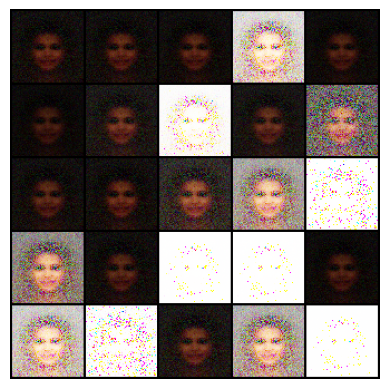

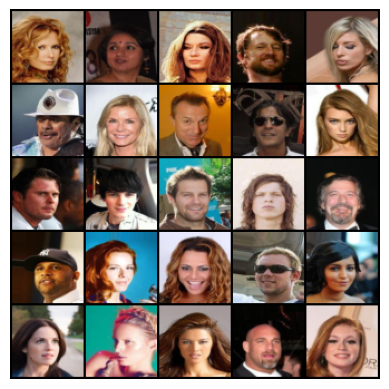

 90%|████████▉ | 1417/1583 [04:20<00:30,  5.42it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 3000: Generator loss: 5.086797518551354, discriminator loss: 0.20012080568075183


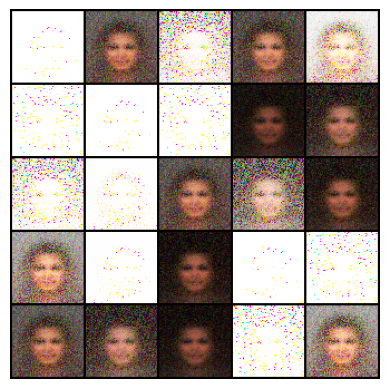

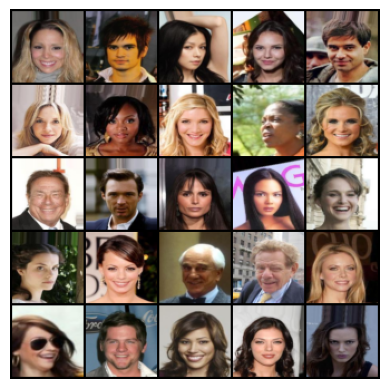

 21%|██        | 334/1583 [01:01<03:41,  5.64it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999999..1.0].


Step 3500: Generator loss: 6.4913055365681664, discriminator loss: 0.2076332741230726


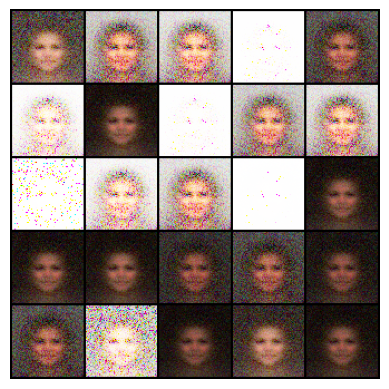

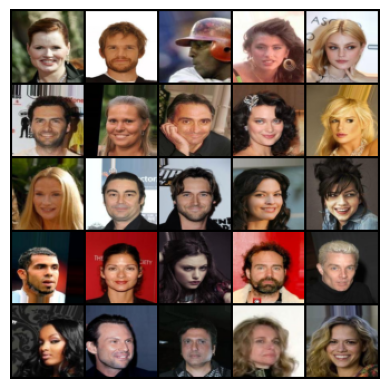

 53%|█████▎    | 834/1583 [02:32<02:18,  5.40it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Step 4000: Generator loss: 6.286988935709001, discriminator loss: 0.23796222060546277


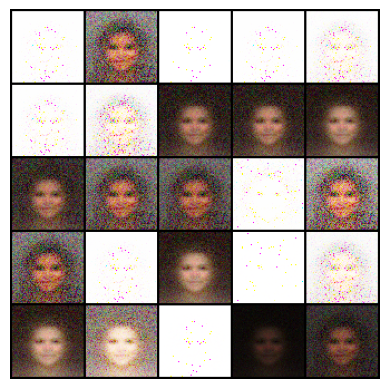

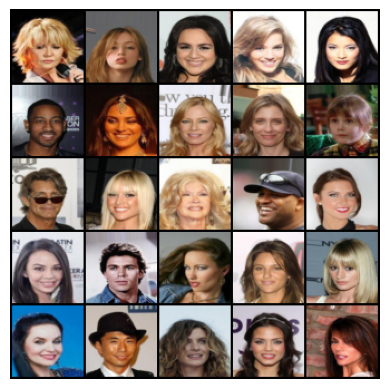

 84%|████████▍ | 1334/1583 [04:04<00:44,  5.65it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999994..1.0].


Step 4500: Generator loss: 3.766526193082335, discriminator loss: 0.40171171501278863


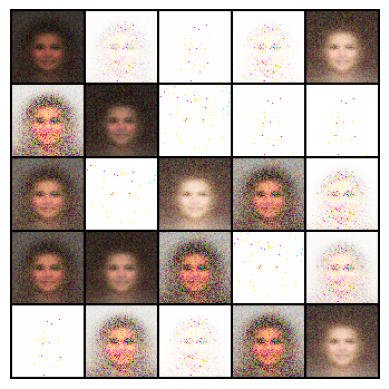

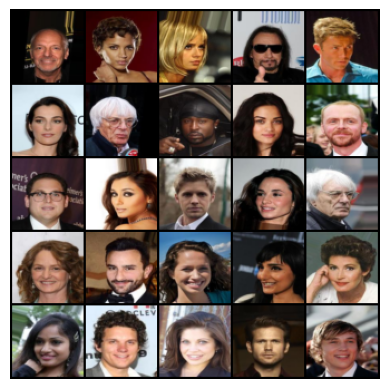

 16%|█▌        | 251/1583 [07:08<03:36,  6.16it/s]    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999869..1.0].


Step 5000: Generator loss: 2.969686916351317, discriminator loss: 0.3854887941777705


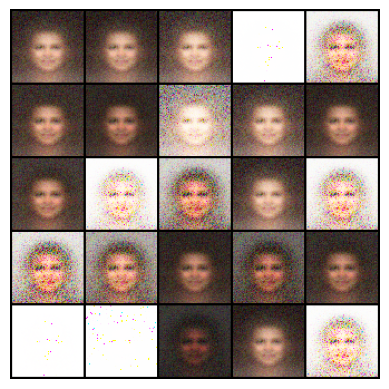

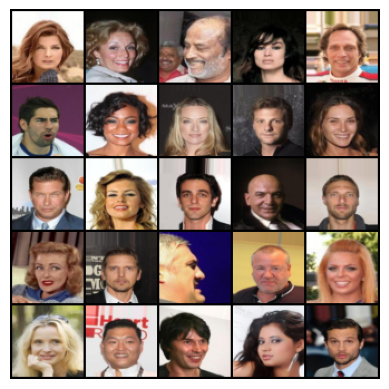

 42%|████▏     | 666/1583 [08:15<02:43,  5.60it/s]

In [17]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: 

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1